In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
# df_sam = pd.read_csv('data/sample_submission.csv')
df = pd.read_csv('data/train.csv')
df_pred = pd.read_csv('data/test.csv')

In [3]:
# Сохраняю id
ids = df_pred['loan_id']

In [4]:
# работа с датами
df['created_at'] = pd.to_datetime(df['created_at'])
df_pred['created_at'] = pd.to_datetime(df_pred['created_at'])

df['day_created_at'] = df.created_at.dt.day
df['month_created_at'] = df.created_at.dt.month
df['year_created_at'] = df.created_at.dt.year - 2021

df_pred['day_created_at'] = df_pred.created_at.dt.day
df_pred['month_created_at'] = df_pred.created_at.dt.month
df_pred['year_created_at'] = df_pred.created_at.dt.year - 2021

In [5]:
df['closed_at'] = pd.to_datetime(df['closed_at'])
df_pred['closed_at'] = pd.to_datetime(df_pred['closed_at'])

df['day_closed_at'] = df.closed_at.dt.day
df['month_closed_at'] = df.closed_at.dt.month
df['year_closed_at'] = df.closed_at.dt.year - 2021

df_pred['day_closed_at'] = df_pred.closed_at.dt.day
df_pred['month_closed_at'] = df_pred.closed_at.dt.month
df_pred['year_closed_at'] = df_pred.closed_at.dt.year - 2021

In [6]:
# преобразую категориальные признаки
category_lst = ['gender', 'client_type.1']

df = pd.get_dummies(df, columns=category_lst, dtype='int')
df_pred = pd.get_dummies(df_pred, columns=category_lst, dtype='int')

In [7]:
drop_lst = ['work_experience', 'requested_sum', 'requested_period_days', 'requested_amount',
            'req_app_amount', 'cnt_ext', 'term', 'price', 'contact_cases', 'start_dt', 'settlement',
           'region', 'loan_id', 'client_id', 'created_at', 'closed_at', 'recurents_sum']
df.drop(columns=drop_lst, inplace=True)
df_pred.drop(columns=drop_lst, inplace=True)

In [8]:
df['monthly_income'] = df['monthly_income'].fillna(df['monthly_income'].median())
df_pred['monthly_income'] = df_pred['monthly_income'].fillna(df_pred['monthly_income'].median())

df['elecs_sum'] = df['elecs_sum'].fillna(df['elecs_sum'].median())
df_pred['elecs_sum'] = df_pred['elecs_sum'].fillna(df_pred['elecs_sum'].median())

df['tamount'] = df['tamount'].fillna(df['tamount'].median())
df_pred['tamount'] = df_pred['tamount'].fillna(df_pred['tamount'].median())

df['nbki_score'] = df['nbki_score'].fillna(df['nbki_score'].median())
df_pred['nbki_score'] = df_pred['nbki_score'].fillna(df_pred['nbki_score'].median())

# Model
Применяю стратегию Undersampling (уменьшение большинства) – уменьшение числа примеров большинства, чтобы сбалансировать распределение классов. Этот метод уменьшает выборку класса, который доминирует, тем самым уменьшая общий объем данных.

Важно помнить, что балансировку данных нужно проводить только на обучающем наборе, а валидационный и тестовый наборы должны оставаться нетронутыми.

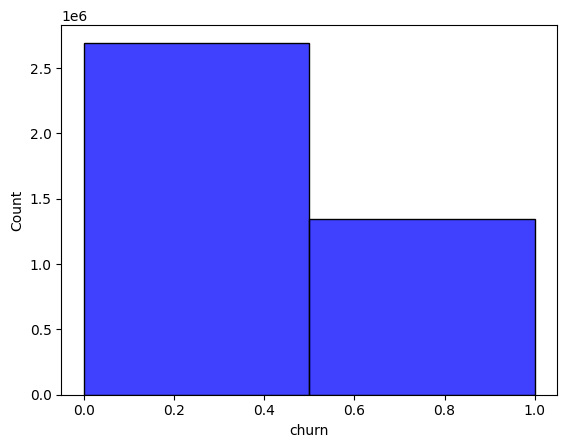

In [16]:
sns.histplot(data=df, x='churn', bins=2, color='blue')
plt.show()

In [14]:
X = df.drop(columns='churn')
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

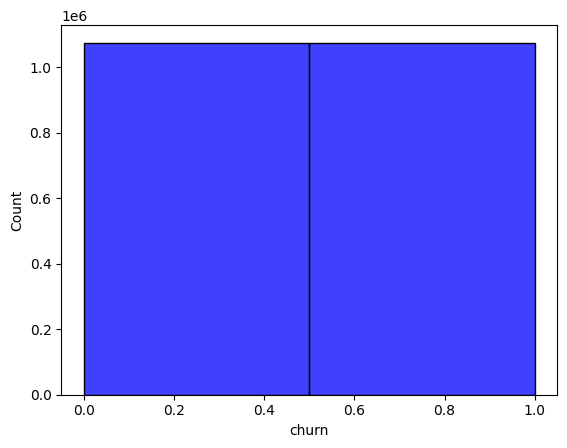

In [17]:
sns.histplot(x=y_train_balanced, bins=2, color='blue')
plt.show()

In [18]:
model = CatBoostClassifier(verbose=1, iterations=10, eval_metric='F1')

model.fit(X_train_balanced, y_train_balanced, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
f_1 = f1_score(y_pred, y_test) 

f_1

Learning rate set to 0.5
0:	learn: 0.6086938	test: 0.5198040	best: 0.5198040 (0)	total: 862ms	remaining: 7.76s
1:	learn: 0.6149594	test: 0.5248551	best: 0.5248551 (1)	total: 1.46s	remaining: 5.85s
2:	learn: 0.6189052	test: 0.5281434	best: 0.5281434 (2)	total: 2.02s	remaining: 4.7s
3:	learn: 0.6193154	test: 0.5307170	best: 0.5307170 (3)	total: 2.58s	remaining: 3.87s
4:	learn: 0.6218294	test: 0.5332290	best: 0.5332290 (4)	total: 3.11s	remaining: 3.11s
5:	learn: 0.6226060	test: 0.5337932	best: 0.5337932 (5)	total: 3.57s	remaining: 2.38s
6:	learn: 0.6256671	test: 0.5355283	best: 0.5355283 (6)	total: 4.14s	remaining: 1.78s
7:	learn: 0.6258338	test: 0.5367309	best: 0.5367309 (7)	total: 4.77s	remaining: 1.19s
8:	learn: 0.6275391	test: 0.5381926	best: 0.5381926 (8)	total: 5.29s	remaining: 588ms
9:	learn: 0.6263233	test: 0.5383784	best: 0.5383784 (9)	total: 5.88s	remaining: 0us

bestTest = 0.5383783856
bestIteration = 9



0.5383783856482641

In [21]:
pred = model.predict(df_pred)

Text(0.5, 0, 'CatBoost Feature Importance')

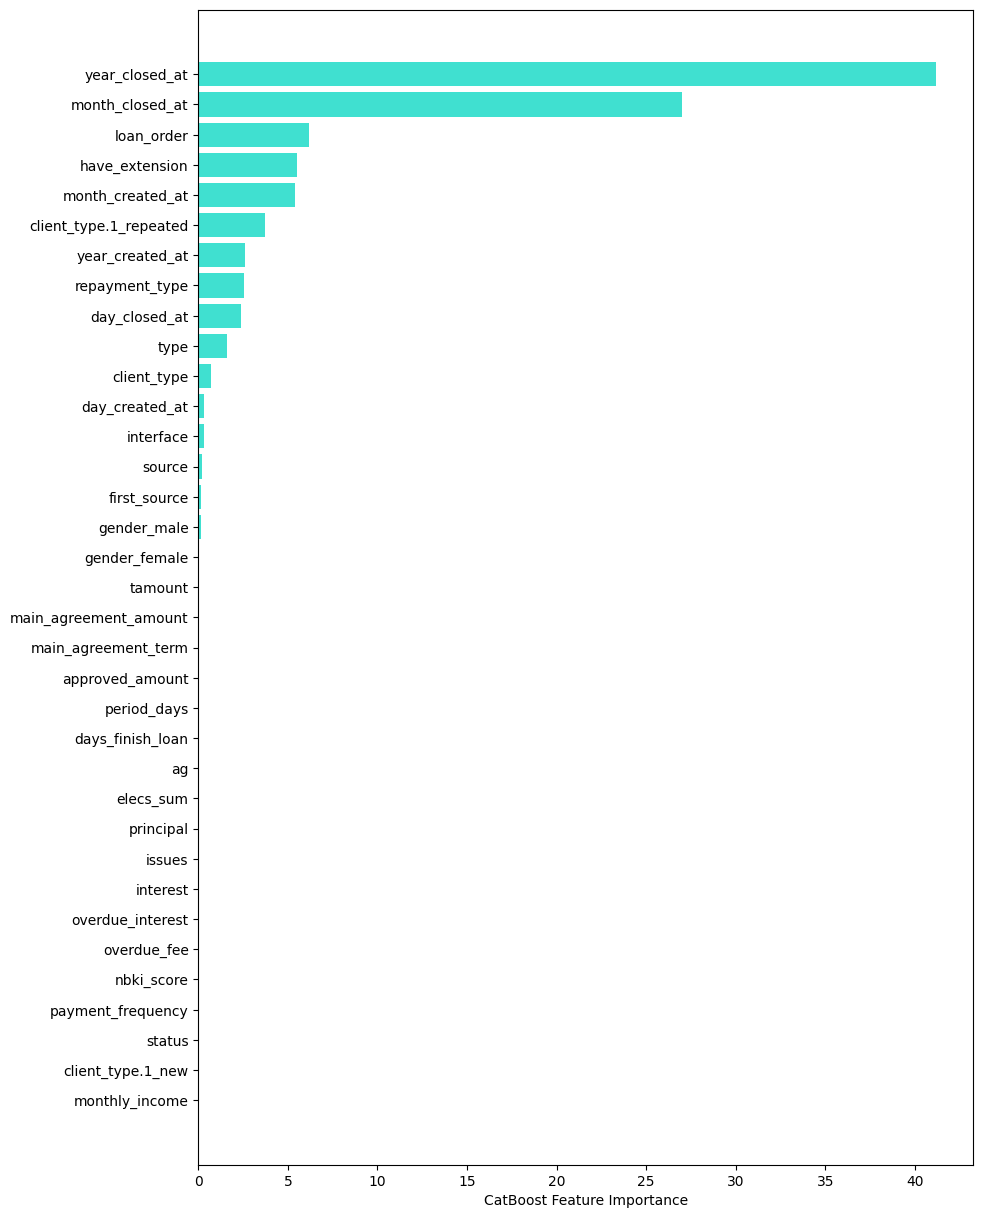

In [19]:
# кареляция каждого столбца
sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(10, 15))
plt.barh(X.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [20]:
# Создаю фрейм данных для хранения названий объектов и их важности
feature_importance_df = pd.DataFrame({
    'Feature': X.columns[sorted_feature_importance],
    'Importance': model.feature_importances_[sorted_feature_importance]
})

# сортирую фрейм данных по важности в порядке убывания
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                   Feature  Importance
34          year_closed_at   41.199442
33         month_closed_at   27.011551
32              loan_order    6.194421
31          have_extension    5.527890
30        month_created_at    5.390537
29  client_type.1_repeated    3.695451
28         year_created_at    2.614314
27          repayment_type    2.530972
26           day_closed_at    2.379266
25                    type    1.609711
24             client_type    0.725817
23          day_created_at    0.307888
22               interface    0.307096
21                  source    0.176178
20            first_source    0.174379
19             gender_male    0.155086
18           gender_female    0.000000
0           monthly_income    0.000000
1        client_type.1_new    0.000000
8                   issues    0.000000
2                   status    0.000000
3        payment_frequency    0.000000
4               nbki_score    0.000000
5              overdue_fee    0.000000
6         overdue_interes

In [22]:
output = pd.DataFrame({'loan_id': ids, 'churn': pred})
output.to_csv('data/out_model.csv', index=False)